# Plot Attention Maps

In [16]:
## Model architecture
N_HEAD = 16
N_LAYER = 8
N_EMBD = 768
VOCAB_SIZE = 50258
SEQ_LENGTH = 384

DATA_PCT = 1 # percent of training data

LOAD_EPOCH = 10

path = '/content/drive/Shareddrives/DSU Better Transformer'

MODEL_NAME = f"bt_{N_LAYER}_LAYERs_{int(DATA_PCT*100)}_DATA_PCT_{N_EMBD}_EMBD_DIM"
print("Model Name:", MODEL_NAME)

Model Name: bt_8_LAYERs_100_DATA_PCT_768_EMBD_DIM
Model will be saved every 5 epochs, and will generate text every 5 epochs


# Imports

In [2]:
%%capture
!pip install transformers

In [129]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm

from transformers import AutoTokenizer

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Setup

In [5]:
def set_seed(seed = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # torch.cuda.manual_seed_all(seed) # if multi-GPU
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark = False

set_seed()

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [7]:
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-1.3B")

if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

tokenizer_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

# Model——MODIFIED to return attention scores!

In [181]:
class MLP(nn.Module):
    def __init__(self, n_embd, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.GELU(), # replaced ReLU
            nn.Dropout(p=dropout),
            nn.Linear(4 * n_embd, n_embd),
        )

    def forward(self, x):
        return self.net(x)

In [182]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_embd, n_head, seq_length, dropout=0.1):
        super().__init__()

        self.n_embd = n_embd
        self.n_head = n_head
        self.head_dim = n_embd // n_head # Dimension of each head's key, query, and value
        assert self.head_dim * n_head == self.n_embd, "n_embd must be divisible by n_head"
        self.seq_length = seq_length
        self.drop = nn.Dropout(p=dropout)

        self.query = nn.Linear(n_embd, n_embd, bias=False)
        self.key = nn.Linear(n_embd, n_embd, bias=False)
        self.value = nn.Linear(n_embd, n_embd, bias=False)
        self.out = nn.Linear(n_embd, n_embd, bias=False) # multi-head combining weight matrix

    def split_heads(self, x):
        B, S, D = x.size()
        # split dimension into n_head * head_dim, then transpose the sequence length w/ n_head
        # output: [B, n_head, S, head_dim]
        return x.view(B, S, self.n_head, self.head_dim).transpose(1, 2)

    def combine_heads(self, x):
        # use permute or transpose to reverse
        # taking a view earlier may produce a non-contiguous tensor, so we convert back because view needs a contiguous input
        B, _, S, head_dim = x.size() # _ is n_head which we will merge
        # output: [B, S, n_embd]
        return x.transpose(1, 2).contiguous().view(B, S, self.n_embd)

    def scaled_dot_product(self, q, k, v, dropout, mask=None):
        # q,k,v are [B, n_head, S, head_dim]
        # the key transpose sets up batch multiplication s.t. wei = [B, n_head, S, S]
        wei = q @ k.transpose(-2,-1) / np.sqrt(self.head_dim)
        # mask is [B, 1, S, S], so simply broadcasted across each head and works as expected
        if mask is not None:
          wei = wei.masked_fill(mask, float('-inf'))
        wei = dropout(F.softmax(wei, dim=-1))
        self.attn_score = wei # extract attention score
        out = wei @ v
        return out

    def forward(self, x, mask=None):
        # x: (B, S, n_embd)
        # Step 1 and 2: Project full query, key, value, then split via reshaping
        q = self.split_heads(self.query(x))
        k = self.split_heads(self.key(x))
        v = self.split_heads(self.value(x))

        # Step 3: Compute scaled dot-product attention with causal mask
        attn = self.scaled_dot_product(q, k, v, self.drop, mask)

        # Step 4 and 5: Concatenate attention scores, return projected output matrix
        out = self.out(self.combine_heads(attn)) # (B, S, n_embd)
        return out, self.attn_score

In [183]:
class Block(nn.Module):
    def __init__(self, n_embd, n_head, seq_length, dropout=0.1):
        super().__init__()
        self.sa = MultiHeadAttention(n_embd, n_head, seq_length, dropout)
        self.mlp = MLP(n_embd, dropout)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        # pre-layer norm
        self.drop = nn.Dropout(p=dropout)

    def forward(self, x, mask):
        # residual connection (stream)
        attn_out, self.attn_score = self.sa(self.ln1(x), mask)
        x = x + self.drop(attn_out)
        x = x + self.drop(self.mlp(self.ln2(x)))

        return x

In [184]:
class PositionalEncoding(nn.Module):
  """
  Formula taken from the original Transformer paper:
  PE(pos, 2i (even)) = sin(pos/(10000^{2i/d_model}))
  PE(pos, 2i+1 (odd)) = cos(pos/(10000^{2i/d_model}))

  See reference for more details:
  https://kikaben.com/transformers-positional-encoding/
  """
  def __init__(self, d_model, max_len):
      # just set d_model = n_embd and max_len = seq_len
      super().__init__()

      position = torch.arange(max_len).unsqueeze(1) # [max_len, 1]
      divisor = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model)) # [d_model / 2, half for each of sin and cos]
      pe = torch.zeros(max_len, d_model)
      pe[:, 0::2] = torch.sin(position * divisor) # 0 for second dim or :?
      pe[:, 1::2] = torch.cos(position * divisor)
      self.register_buffer('pe', pe) # result: self.pe = [max_len, d_model], mapping each token index to a vector of length d_model as desired

  def forward(self, x):
      # x = torch.arange(seq_length) has shape [seq_length], so x.size(0) extracts it, then we index self.pe for the first seq_length mappings
      # note we do not add the positional embeddings to x itself yet, we simply return them
      # output = (seq_length, d_model=n_embd)
      return self.pe[:x.size(0)]

In [185]:
class BetterTransformer(nn.Module):
    def __init__(self, vocab_size, seq_length,
                 n_embd, n_head, n_layer,
                 pad_idx, eos_idx,
                 device, dropout=0.1):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, n_embd, padding_idx=pad_idx)
        self.position_embedding = PositionalEncoding(n_embd, seq_length)
        self.blocks = nn.Sequential(*[Block(n_embd,
                                            n_head,
                                            seq_length,
                                            dropout) for _ in range(n_layer)])
        self.lm_head = nn.Linear(n_embd, vocab_size)
        self.drop = nn.Dropout(dropout)
        self.seq_length = seq_length
        self.pad_idx = pad_idx
        self.eos_idx = eos_idx
        self.device = device
        self.init_params()

    # optional weight initialization (Xavier uniform)
    def init_params(self, default_initialization=False):
        if not default_initialization:
            for name, p in self.named_parameters():
                if p.dim() > 1:
                    nn.init.xavier_uniform_(p)

    # Remark: Xavier normal is not supported at this time.

    def get_causal_mask(self, x):
        """
        Generates causal mask for decoding
        """
        seq_len = x.size(-1) # x = (batch_size x seq_len)
        attn_shape = (1, seq_len, seq_len)
        subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8') # k = 1 shifts the diagonal, so that the main diagonal gets 0's
        return (torch.from_numpy(subsequent_mask) == 0).to(self.device) # (1, seq_len x seq_len)
        # True along main diagonal + below, False elsewhere

    def get_pad_mask(self, x, pad_idx):
        """
        Generates padding mask
        """
        return (x != pad_idx).unsqueeze(1).unsqueeze(-2).to(self.device)
        # (batch_size x 1 x 1 x seq_len)

    def forward(self, x, targets=None):

        # should alr be int64 tokens but explicit cast in case
        x = x.to(torch.int64)
        B, S = x.shape

        # attn scores
        attn_scores = []

        # get mask
        mask = self.get_pad_mask(x, self.pad_idx) & self.get_causal_mask(x).to(self.device)
        # mask = (batch_size x 1 x seq_len x seq_len)

        tok_emb = self.token_embedding(x)
        pos_emb = self.position_embedding(torch.arange(S))
        x = self.drop(tok_emb + pos_emb)
        # (B, S, n_embd)
        for block in self.blocks:
            x = block(x, ~mask) # (batch_size, seq_length, n_embd)
            attn_scores.append(block.attn_score)
        attn_scores = torch.stack(attn_scores)
        # negate mask to fill originally False values with -inf later
        logits = self.lm_head(x) # (batch_size, seq_length, vocab_size)

        # this code assumes teacher forcing——for each text of seq length S we have S autoregressive predictions,
        # thus we have B*S logits and B*S targets
        if targets is None:
            loss = None
        else:
            B, S, C = logits.shape
            logits = logits.view(B*S, C)
            targets = targets.view(B*S)
            loss = F.cross_entropy(logits, targets, ignore_index=self.pad_idx)
            # note we ignore the padding token to avoid wasting compute on learning PAD -> PAD, etc.

        return logits, loss, attn_scores


    def generate(self, input_ids, method='multinomial',
                 max_new_tokens=1000, temp=None,
                 num_beams=None, p_nucleus=None, k=None):

        # TODO: see Huggingface's .generate() function
        # https://huggingface.co/transformers/v3.4.0/_modules/transformers/generation_utils.html

        # Assertions, other complex logic, etc., are built into the generate_inference function.
        # When model.generate is called with generate_train, arguments are fixed.

        # input_ids begins as (batch_size, seq_length)

        self.eval()

        for _ in range(max_new_tokens):
            # for future compatibility, if method == beam, will take a different approach I believe
            if method in ['multinomial', 'temperature', 'greedy', 'nucleus', 'top-k']:
                # i) Truncate to the most recent `max length` tokens
                text_cond = input_ids[:, -self.seq_length:]
                # ii) Retrieve predictions
                with torch.no_grad():
                    logits, _, _ = self(text_cond) # no loss because no targets ofc. attn scores irrelevant also
                # model output: (batch_size, seq_length, vocab_size)
                # iii) Find last token logits of each
                logits = logits[:, -1, :] # (batch_size, vocab_size)

                # aside: if temperature sampling, divide logits by temp before applying softmax
                if method == 'temperature':
                    logits = logits / temp

                # iv) Take softmax along each
                probs = F.softmax(logits, dim=-1)

                # v) Sample next token depending on method
                if method == 'greedy':
                    next_idx = probs.argmax(dim=-1).unsqueeze(-1)

                elif method in ['multinomial', 'temperature', 'nucleus', 'top-k']:
                    if method == 'nucleus':
                        assert p_nucleus is not None and (0 < p_nucleus) and (p_nucleus <= 1)

                        sorted_probs, sorted_idx = probs.sort(dim=-1, descending=True)
                        prob_cumsum = sorted_probs.cumsum(dim=-1)
                        idx_remove = prob_cumsum > p_nucleus
                        # shift one right to ensure the first token is above the threshold
                        idx_remove[..., 1:] = idx_remove[..., :-1].clone()
                        idx_remove[..., 0] = False
                        # retrieve original indices by reverse-sorting
                        remove_mask = idx_remove.gather(dim=-1,
                                          index=sorted_idx.argsort(dim=-1))
                        # ^ specifically, we do this by first argsorting the indices which were returned from argsort. this is crazy y'all
                        # you can show that this returns indices that when used to subset a sorted array, returns the original array in unsorted order
                        # https://stackoverflow.com/questions/52127723/pytorch-better-way-to-get-back-original-tensor-order-after-torch-sort
                        # torch.gather is how we apply a multi-dimensional index
                        # https://stackoverflow.com/questions/50999977/what-does-the-gather-function-do-in-pytorch-in-layman-terms
                        probs[remove_mask] = 0

                    if method == 'top-k':
                        remove_mask = probs < torch.topk(probs, k).values[..., -1, None] # the topk returns (B, 1), leaving only the
                        # kth largest probs (i.e. the cutoff value for each). Then mask is same size as probs (B, vocab_size)
                        probs[remove_mask] = 0

                    # Sample probabilistically via scores
                    next_idx = torch.multinomial(probs, num_samples=1) # (batch_size, 1)

                # vi) Autoregressively append to input_text
                input_ids = torch.cat((input_ids, next_idx), dim=-1)
                # end prematurely if <EOS> generated
                if next_idx == self.eos_idx:
                  break
                # now input_text = (batch_size, seq_length + 1)

        return input_ids

# Load in trained model

In [188]:
model = BetterTransformer(VOCAB_SIZE, SEQ_LENGTH, N_EMBD, N_HEAD, N_LAYER,
                          tokenizer.pad_token_id, tokenizer.eos_token_id, device).to(device)
model.load_state_dict(torch.load(f'{path}/model/{MODEL_NAME}_epoch_{LOAD_EPOCH}.pt',
                                  map_location=device)["model_state_dict"])

<All keys matched successfully>

In [187]:
print(f'Number of model parameters: {sum(p.numel() for p in model.parameters())}')

Number of model parameters: 133924946


# Generate + Plot Attention

In [190]:
cond = 'One morning, Jack woke up and got out of'
cond_tokens = torch.tensor(tokenizer(cond).input_ids).unsqueeze(0).long().to(device)

In [191]:
model.eval()
with torch.no_grad():
  logits, loss, attn_scores = model(cond_tokens)

In [193]:
attn_scores.shape # [N_LAYERS, B, N_HEADS, S, S]

torch.Size([8, 1, 16, 10, 10])

In [198]:
# let's do layer 1 for now. also the 2nd [0] is so we look at a single instance in the batch
attn_scores_block_1_head_1 = attn_scores[0][0][0]
# shape: S x S

In [259]:
# retrieve individual token strings
tokens = [tokenizer.decode(cond_tokens[0][i]) for i in range(len(cond_tokens[0]))]

Text(0.5, 1.0, 'Block 1 Head 1 Attention')

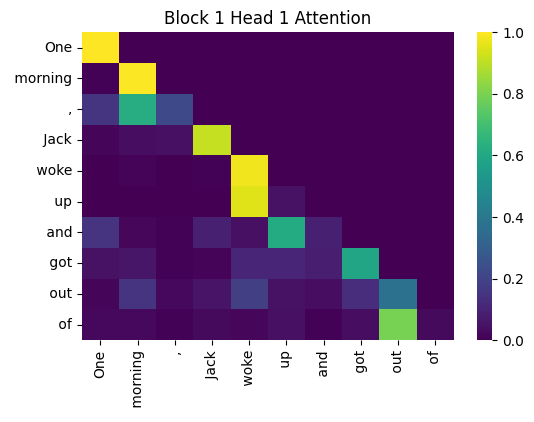

In [264]:
plt.figure(figsize=(6,4))
sns.heatmap(attn_scores_block_1_head_1, cmap='viridis',
            xticklabels=tokens, yticklabels=tokens)
plt.title('Block 1 Head 1 Attention')

Observations:  
-Causal mask on the upper triangular portion  
-Tokens generally attending most strongly to themselves

# Layer 0

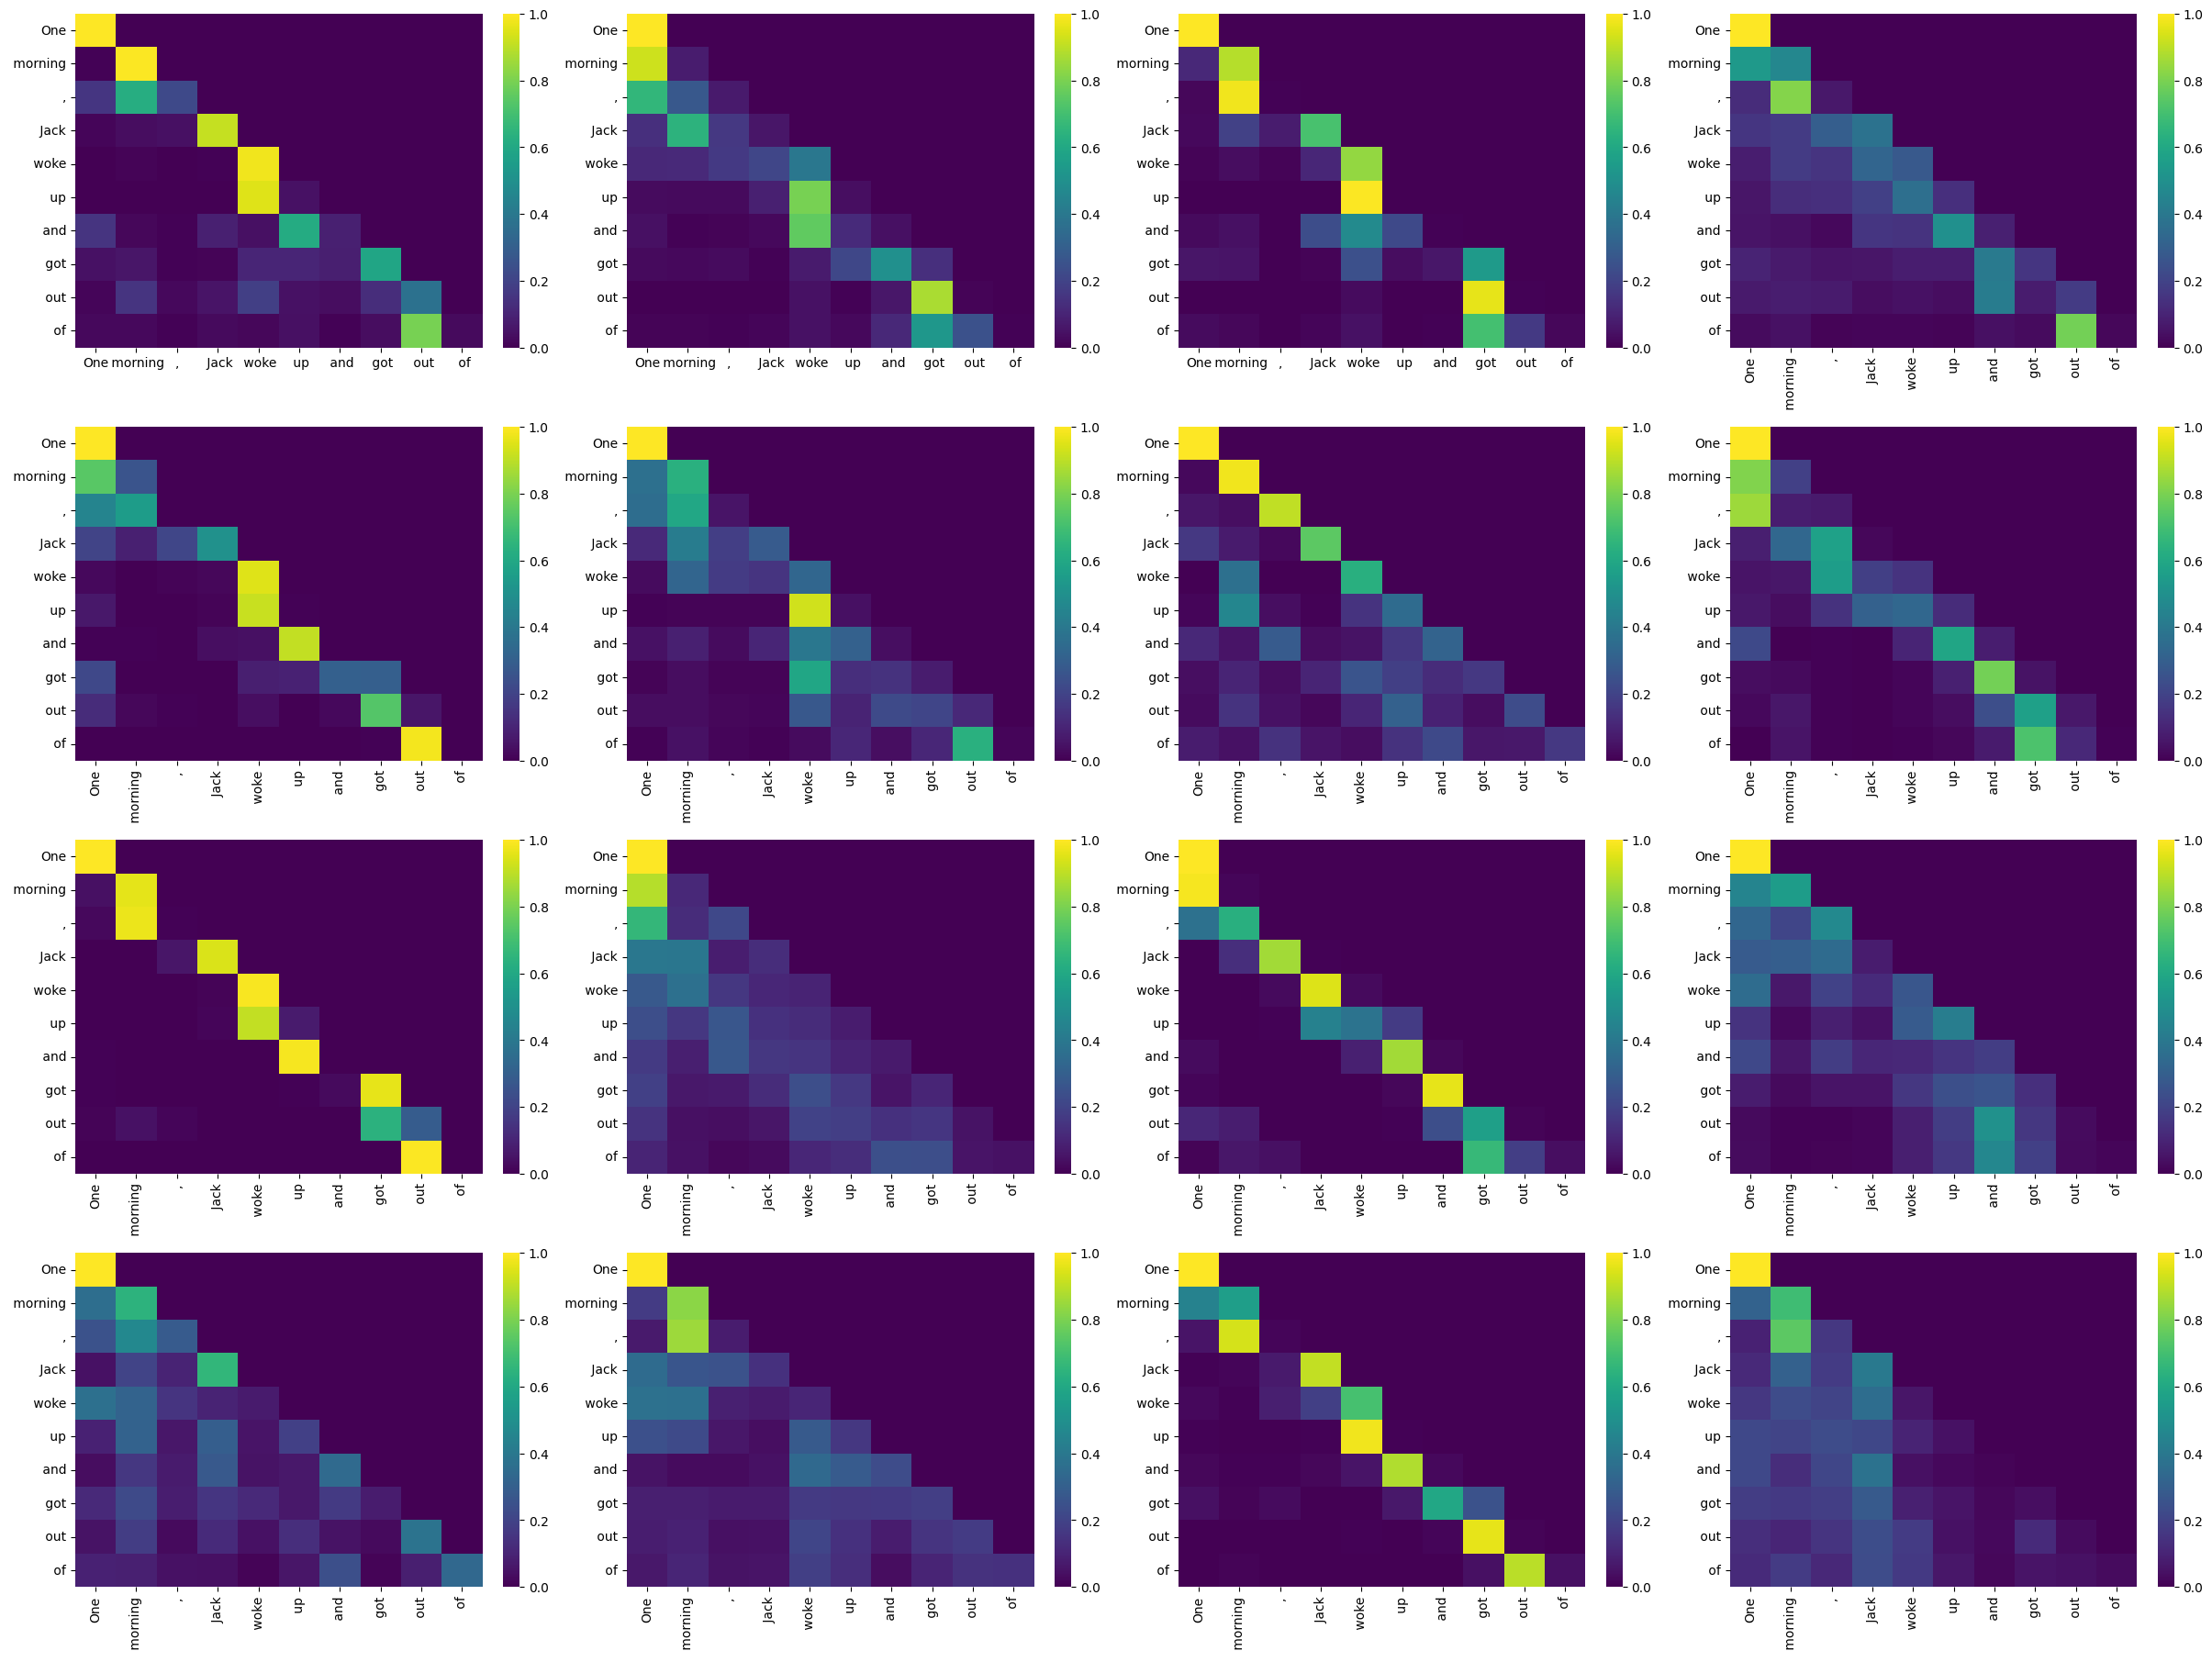

In [306]:
# ~ 45 sec

fig, axes = plt.subplots(4, 4, figsize=(24,18), constrained_layout=True)

for i, ax in enumerate(axes.ravel()):
  attn_score_head = attn_scores[0][0][i]
  sns.heatmap(attn_score_head, cmap='viridis',
            xticklabels=tokens, yticklabels=tokens, ax=ax)

plt.show()

# Layer 3

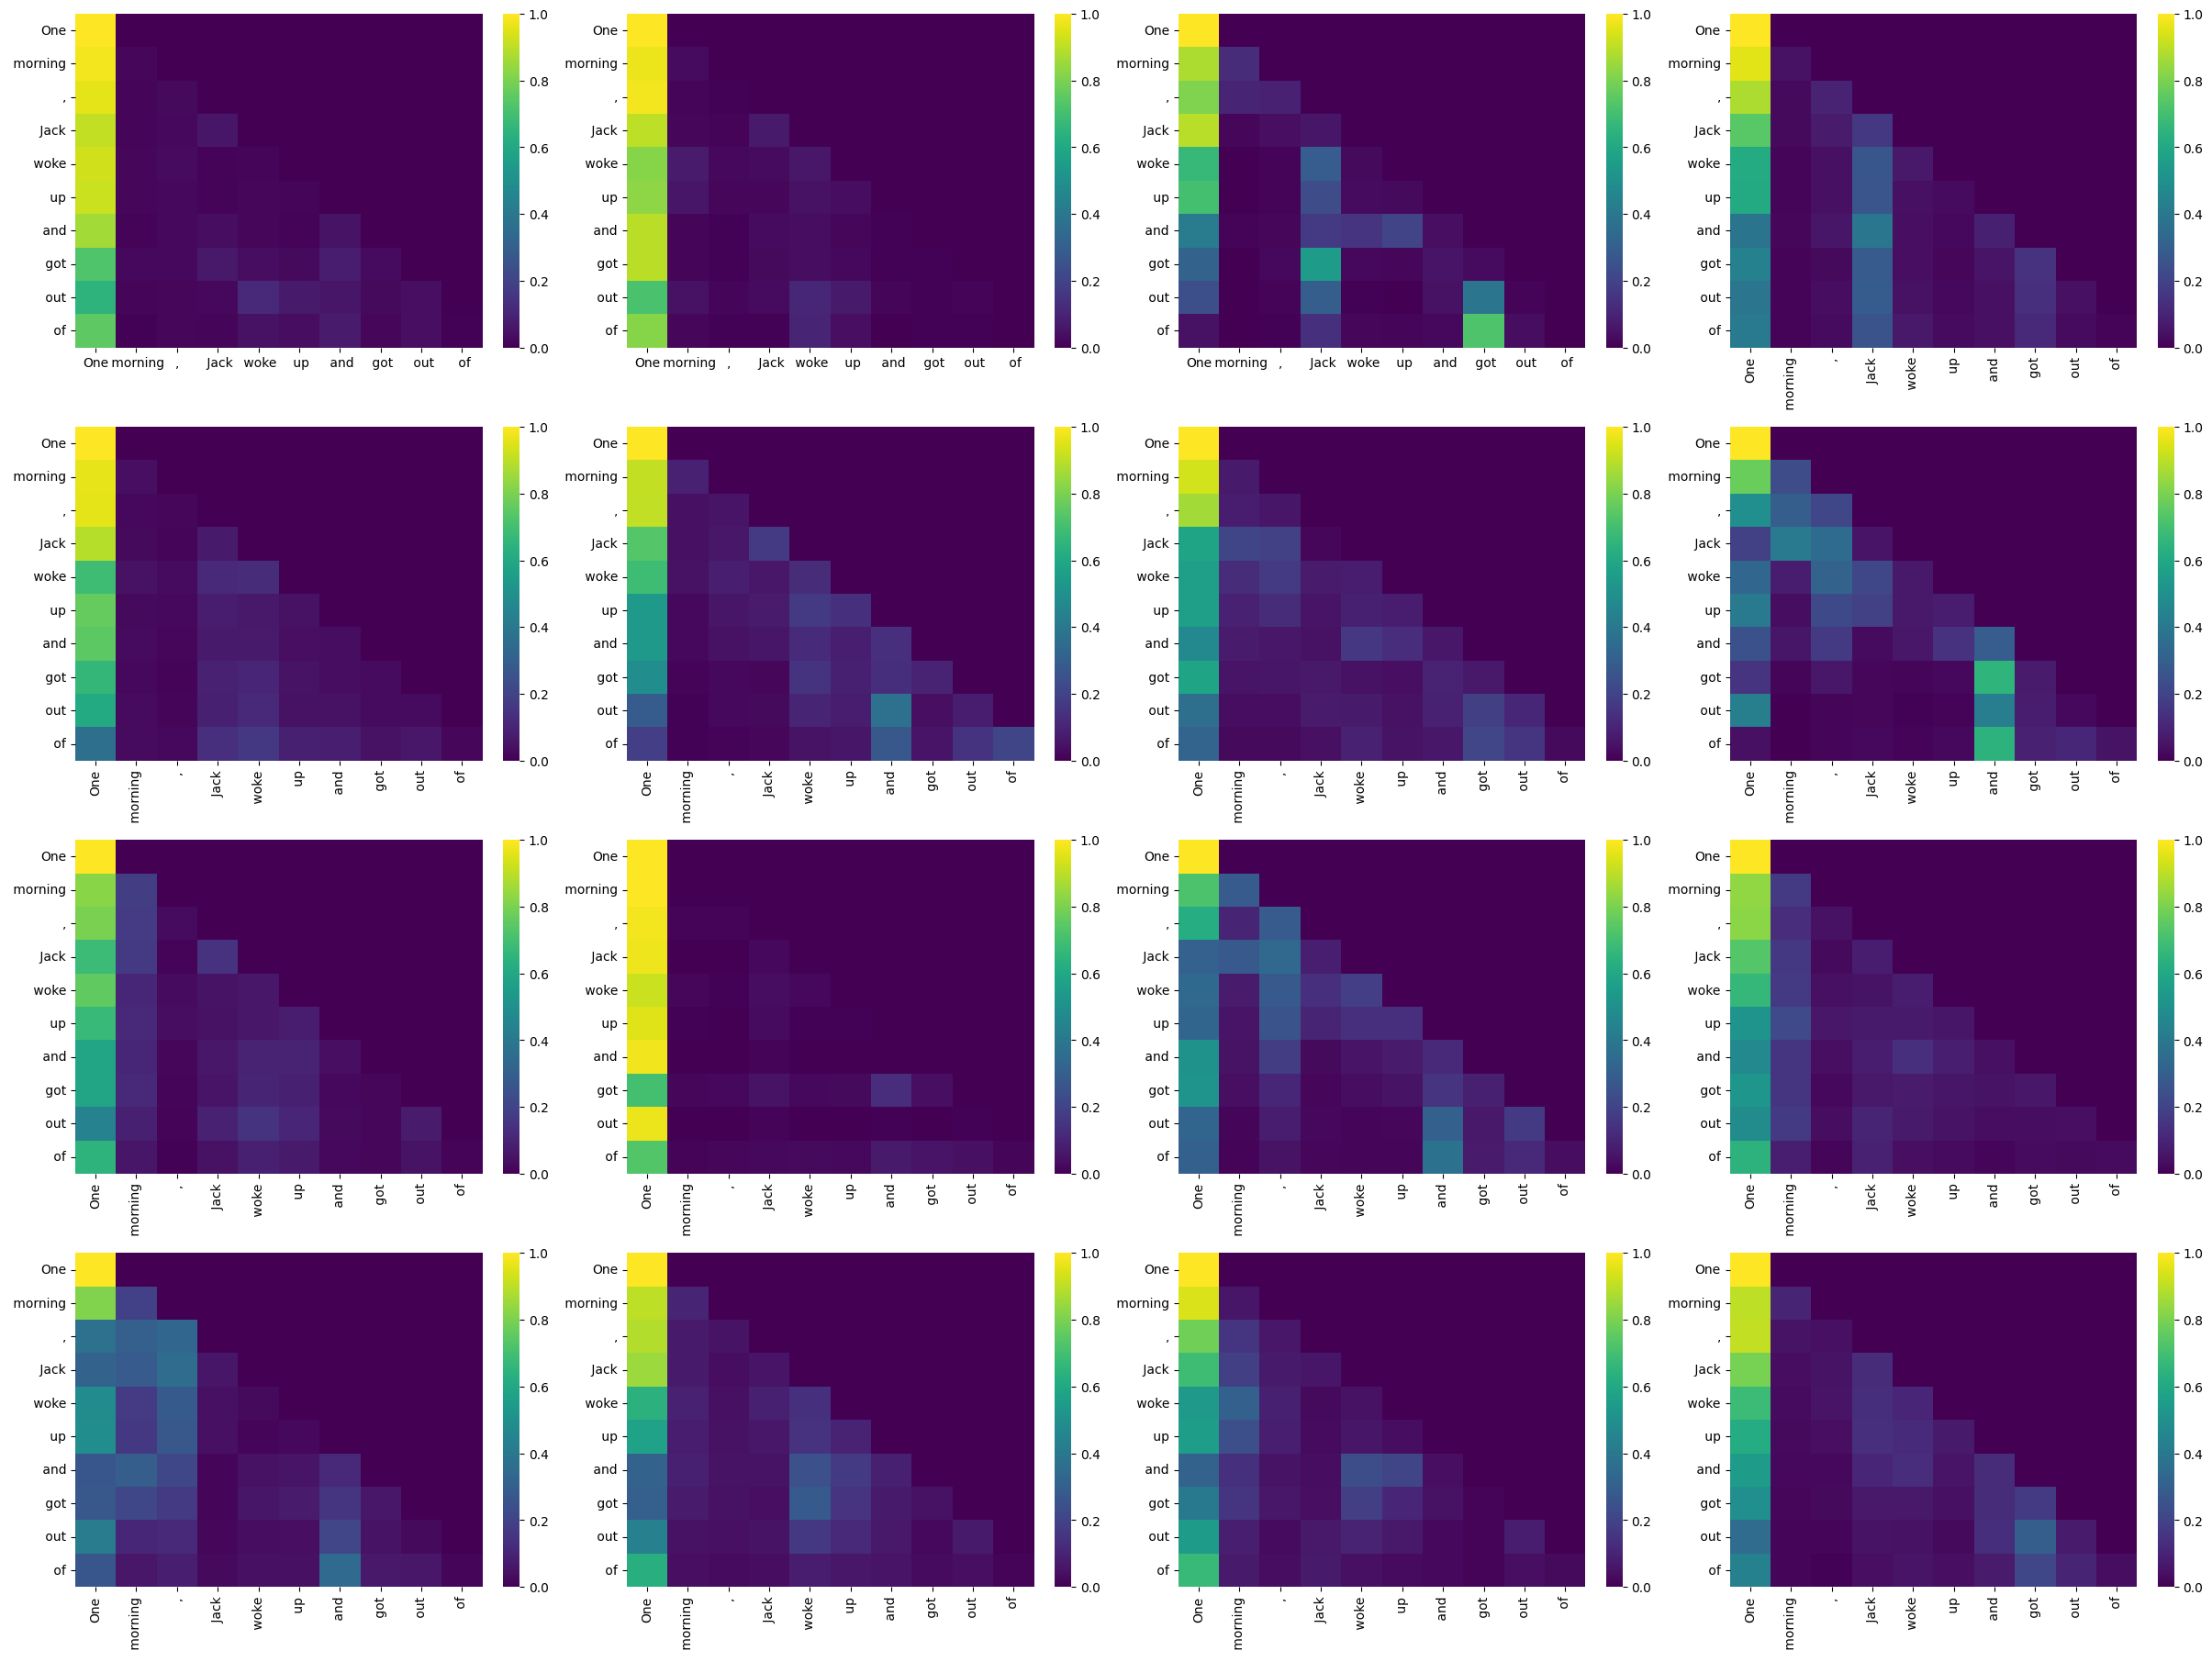

In [305]:
fig, axes = plt.subplots(4, 4, figsize=(24,18), constrained_layout=True)

for i, ax in enumerate(axes.ravel()):
  attn_score_head = attn_scores[3][0][i]
  sns.heatmap(attn_score_head, cmap='viridis',
            xticklabels=tokens, yticklabels=tokens, ax=ax)

plt.show()

Note how *in later layers, every token pays most of its attention only to the very first token.* This is consistent with the idea of **attention sinks** [Efficient Streaming Language Models w/ Attention Sinks (Xiao et al. (Sep 2023))](https://arxiv.org/abs/2309.17453).

# Plot Attention Function

In [326]:
def plot_layer_attention(prompt,
                         model,
                         tokenizer,
                         layer_idx,
                         device):
    prompt_tokens = torch.tensor(tokenizer(prompt).input_ids).unsqueeze(0).long().to(device) # tokenize
    tokens = [tokenizer.decode(prompt_tokens[0][i]) for i in range(len(prompt_tokens[0]))] # decode into individual token strings for labelling

    # forward pass
    model.eval()
    with torch.no_grad():
        _, _, attn_scores = model(prompt_tokens)

    # plotting takes 45s - 1 min
    # 4 x 4 = 16 heads hard-coded
    fig, axes = plt.subplots(4, 4, figsize=(26,20), constrained_layout=True)
    ## TODO: configure fig size properly, longer prompts/tokens may cause issues
    for i, ax in enumerate(axes.ravel()):
        attn_score_head = attn_scores[layer_idx][0][i] # second 0 accesses batch size 1
        sns.heatmap(attn_score_head, cmap='viridis',
              xticklabels=tokens, yticklabels=tokens, ax=ax)
        ax.set_title(f'Head {i}')

    plt.suptitle(f'Layer {layer_idx} Attention', fontsize=20)
    plt.savefig(f"{path}/figures/{MODEL_NAME}_epoch_{LOAD_EPOCH}_layer_{layer_idx}.png")
    plt.show()

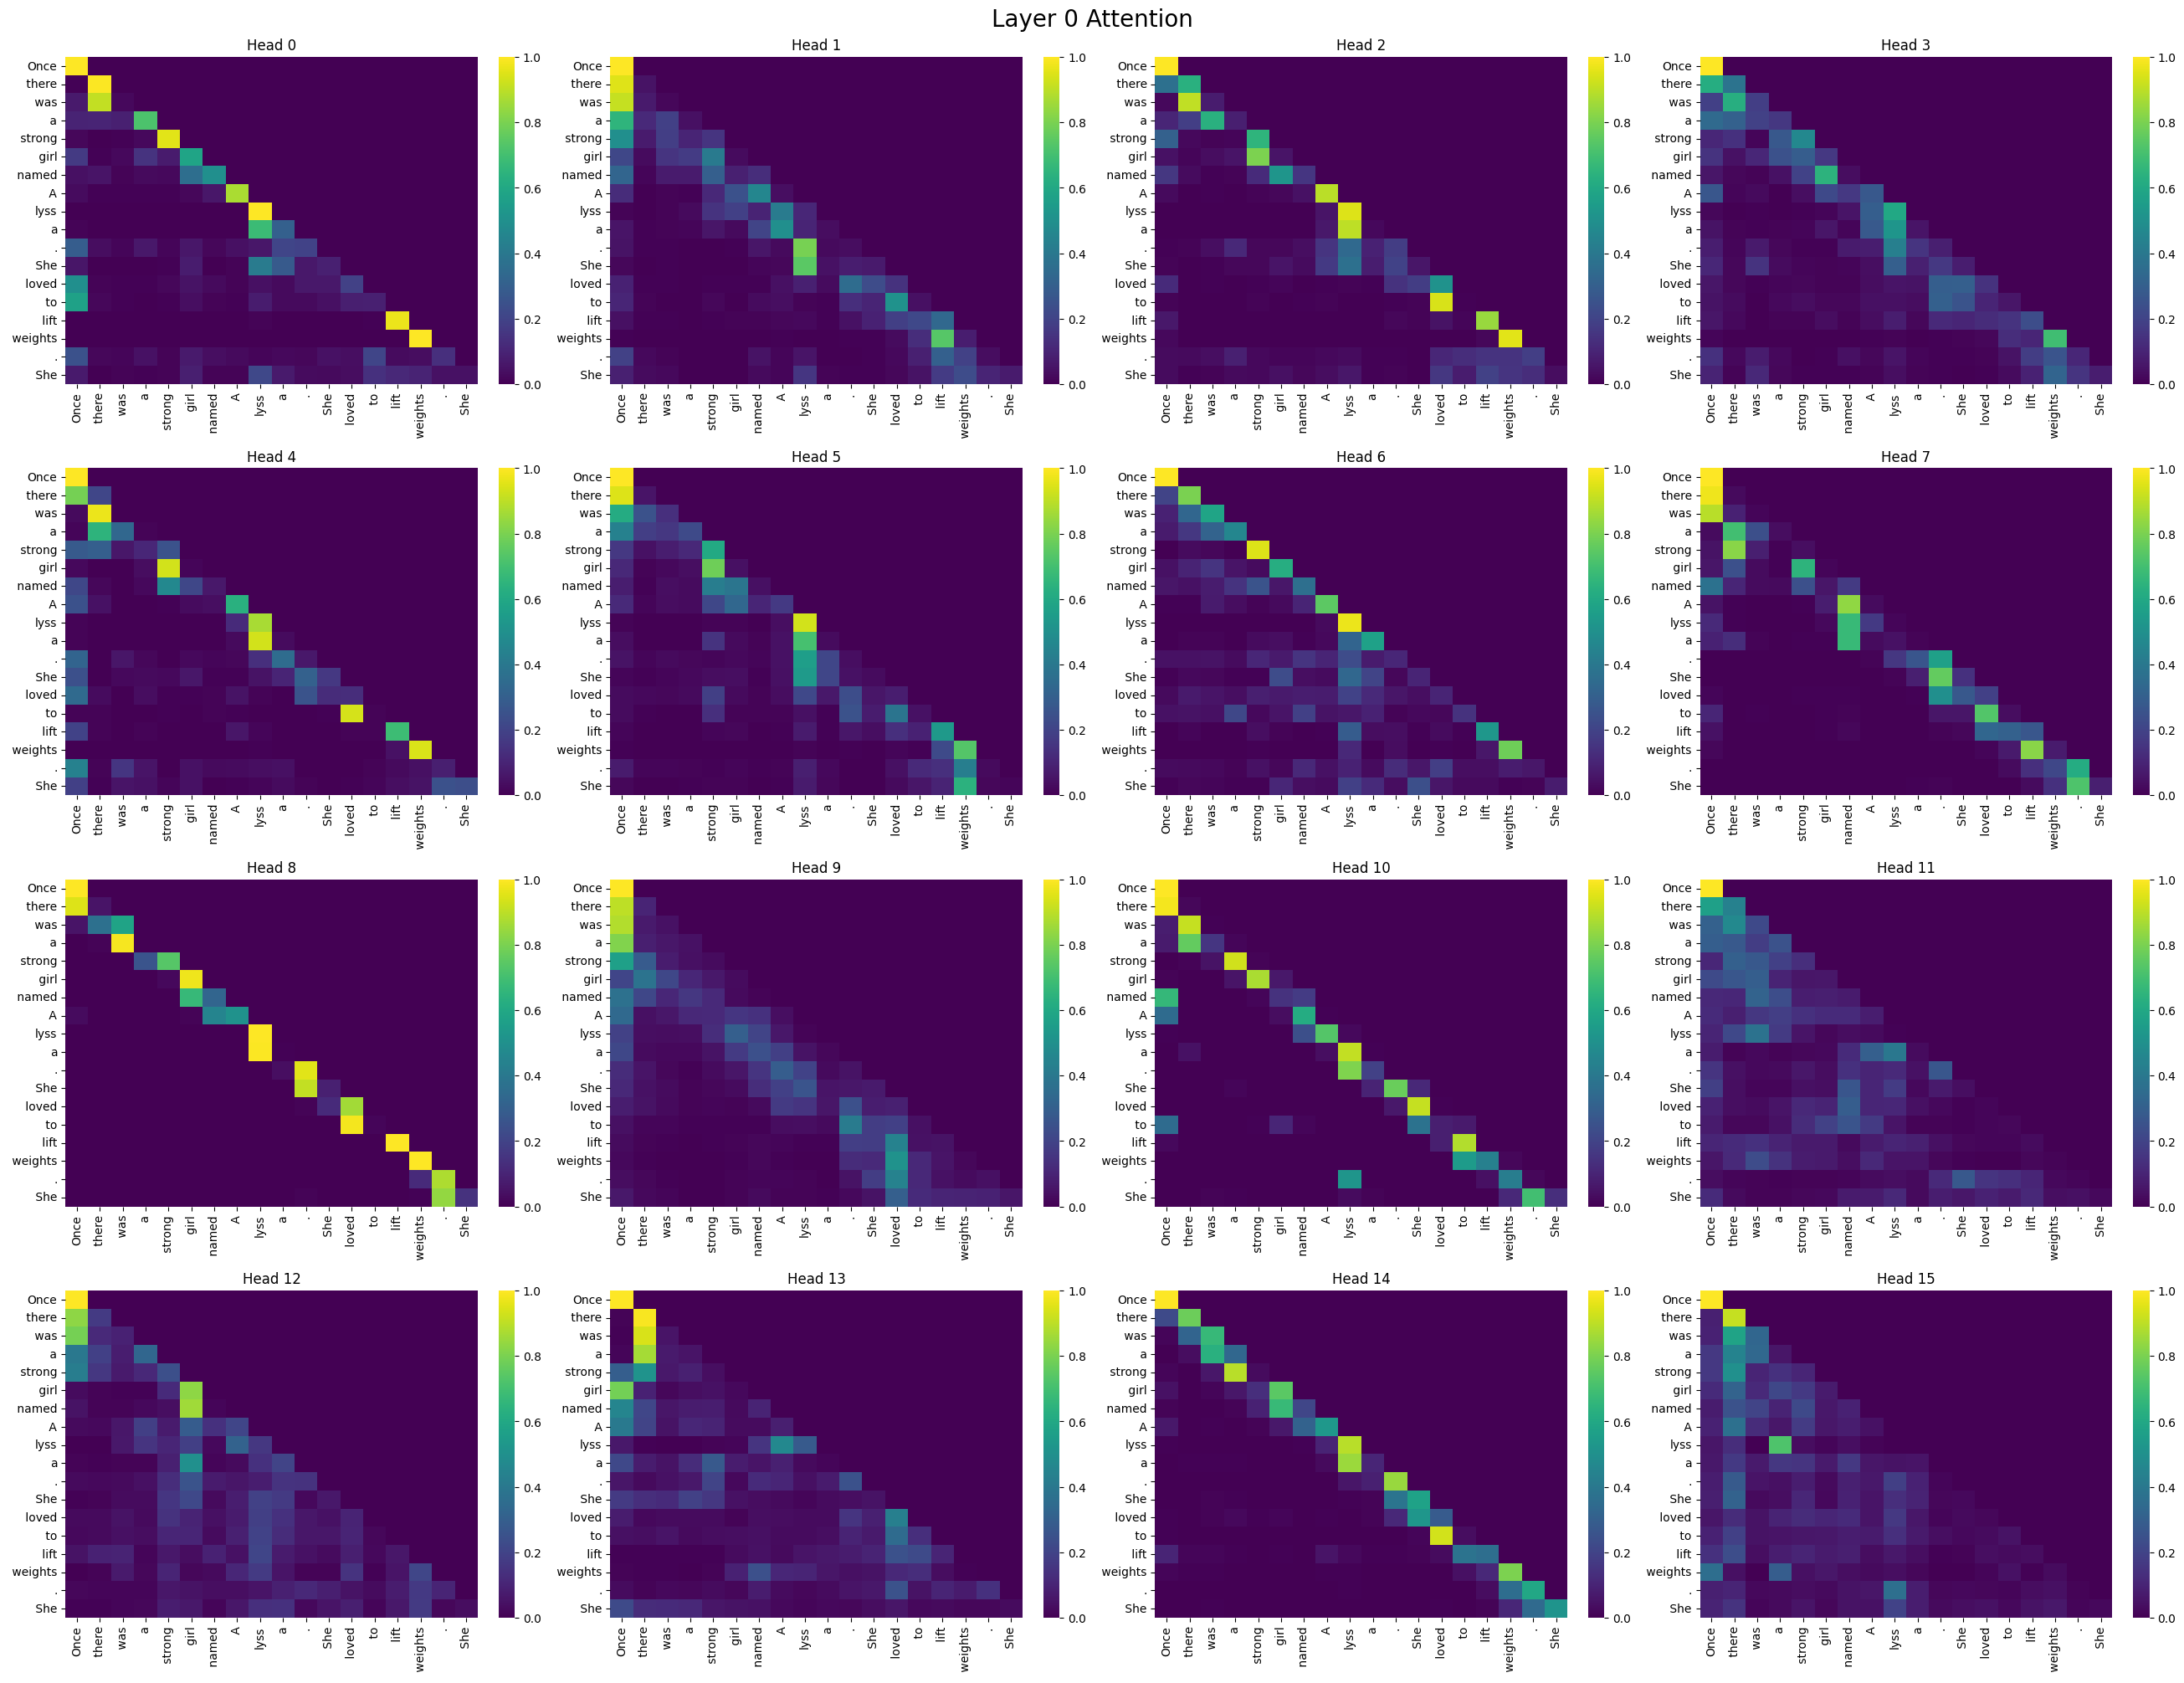

In [327]:
plot_layer_attention("Once there was a strong girl named Alyssa. She loved to lift weights. She",
                      model,
                      tokenizer,
                      layer_idx=0,
                      device=device)

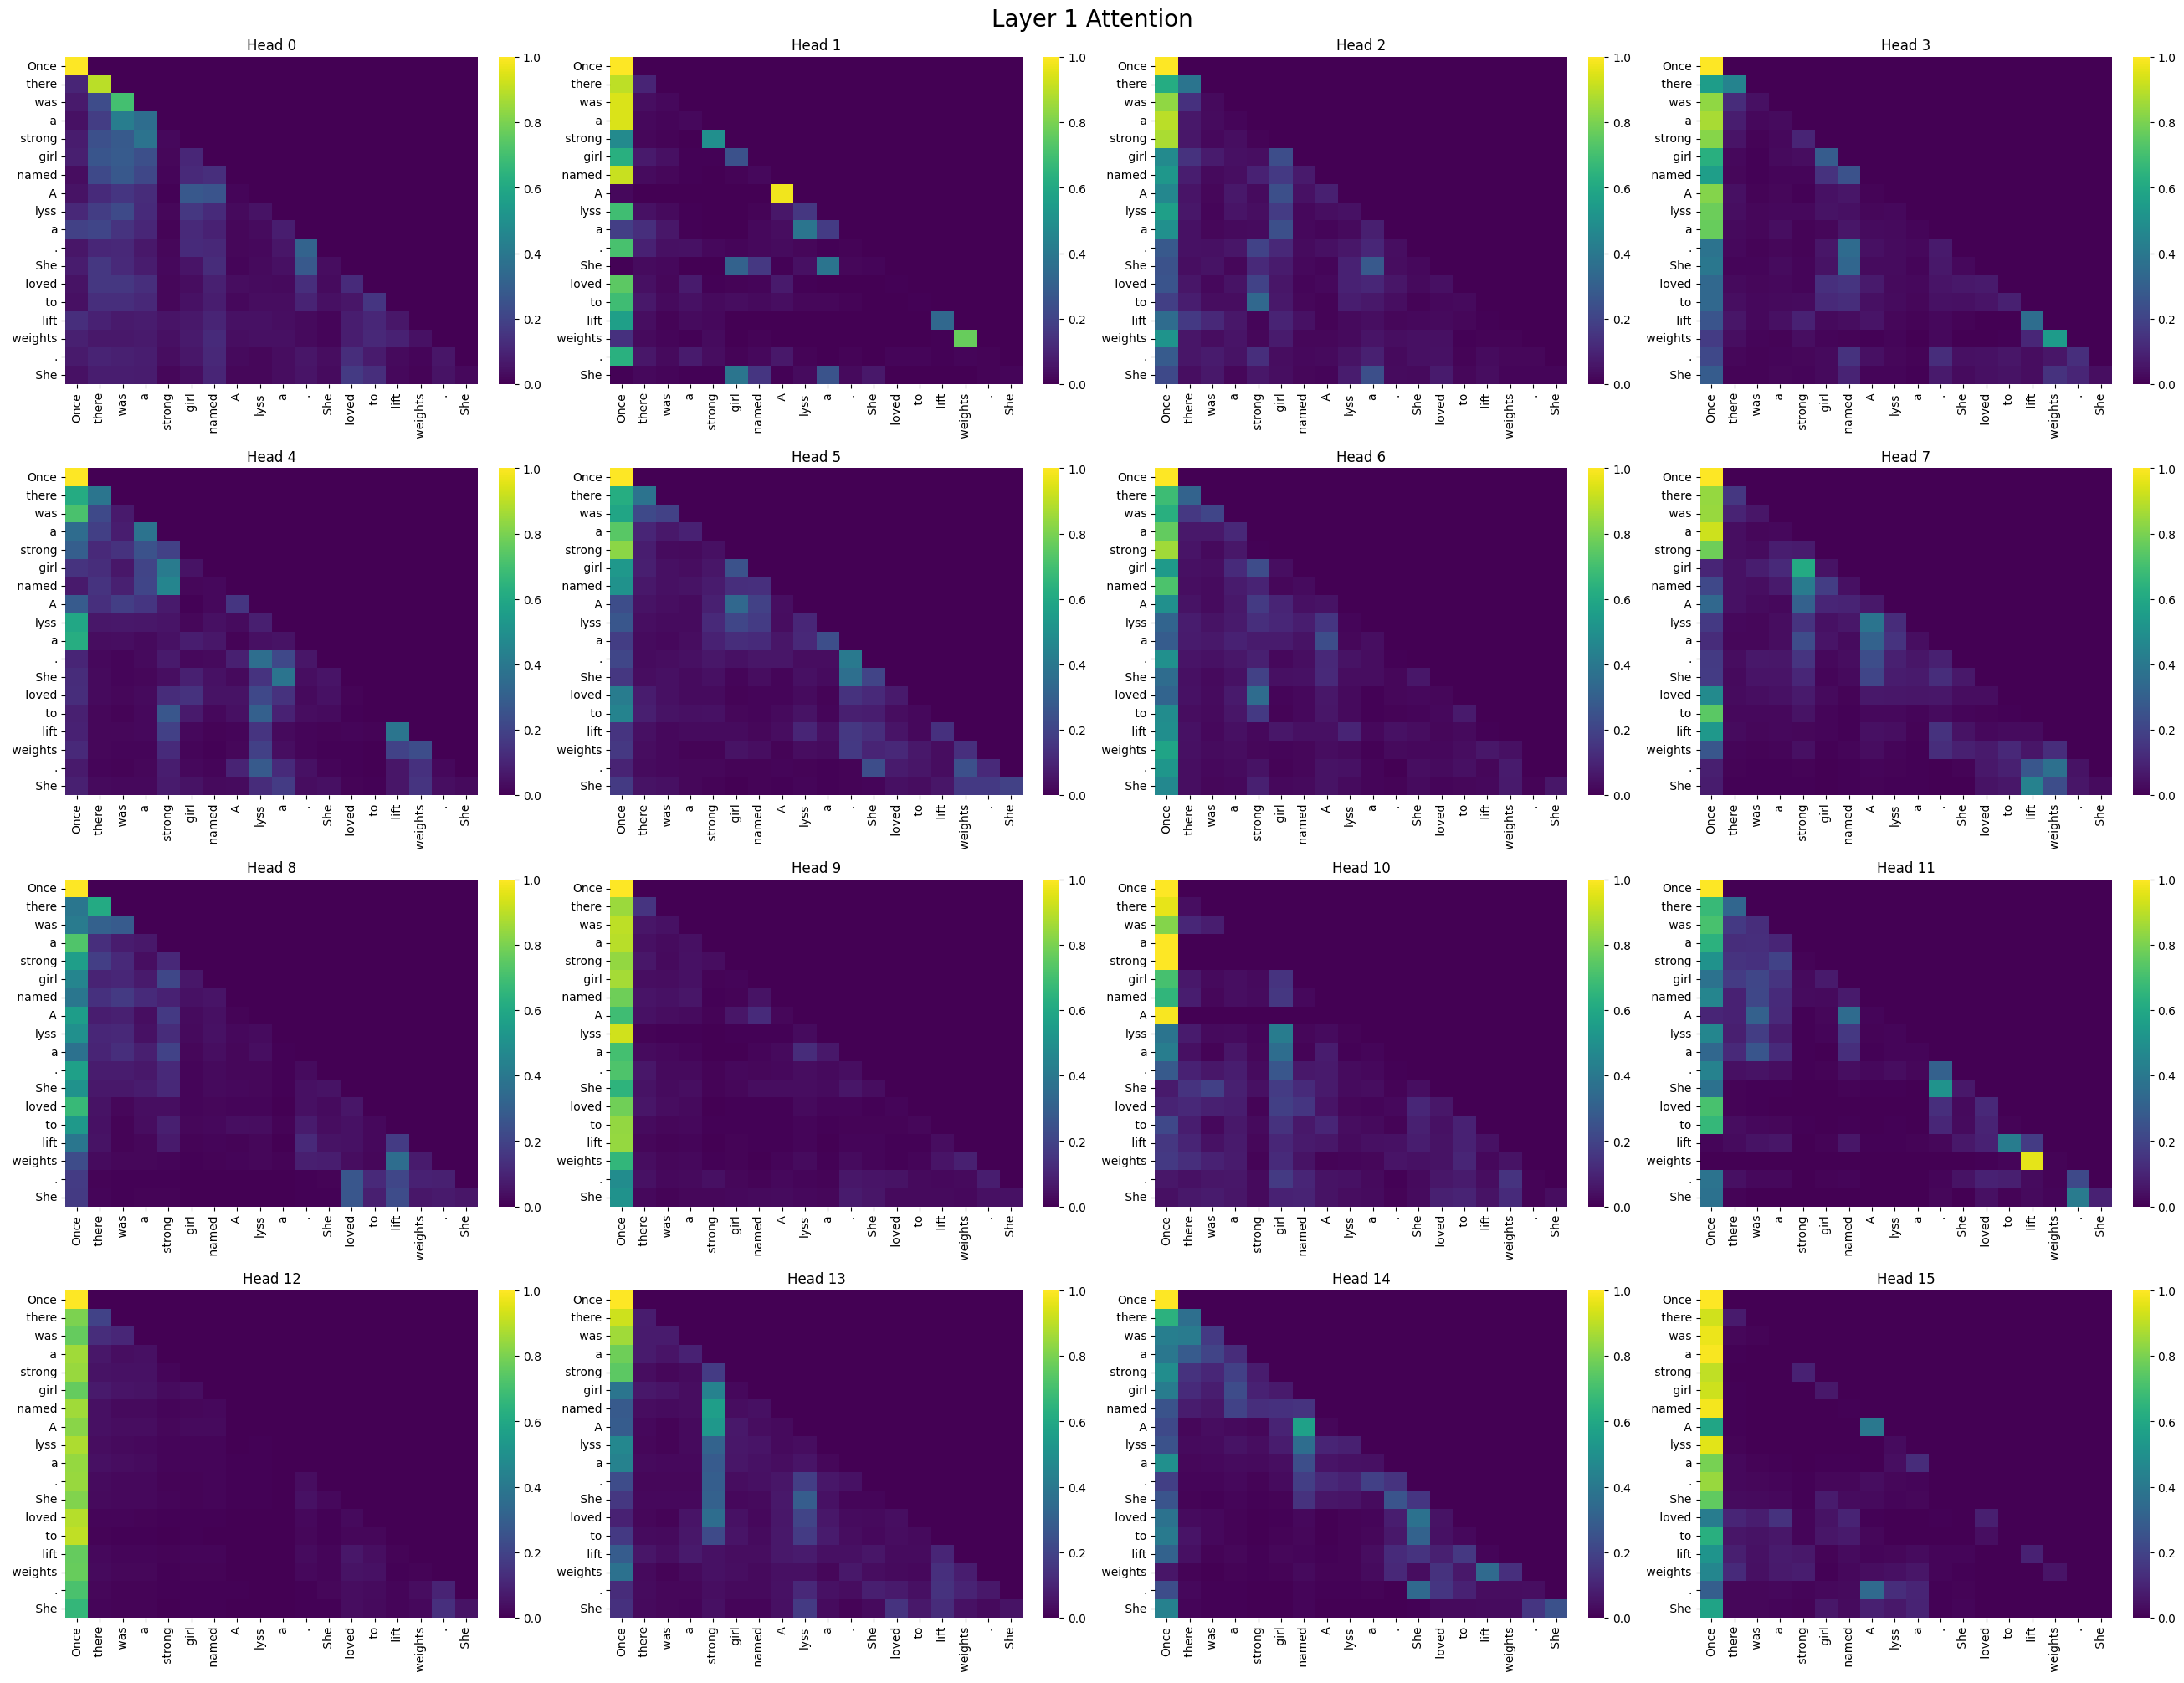

In [328]:
plot_layer_attention("Once there was a strong girl named Alyssa. She loved to lift weights. She",
                      model,
                      tokenizer,
                      layer_idx=1,
                      device=device)

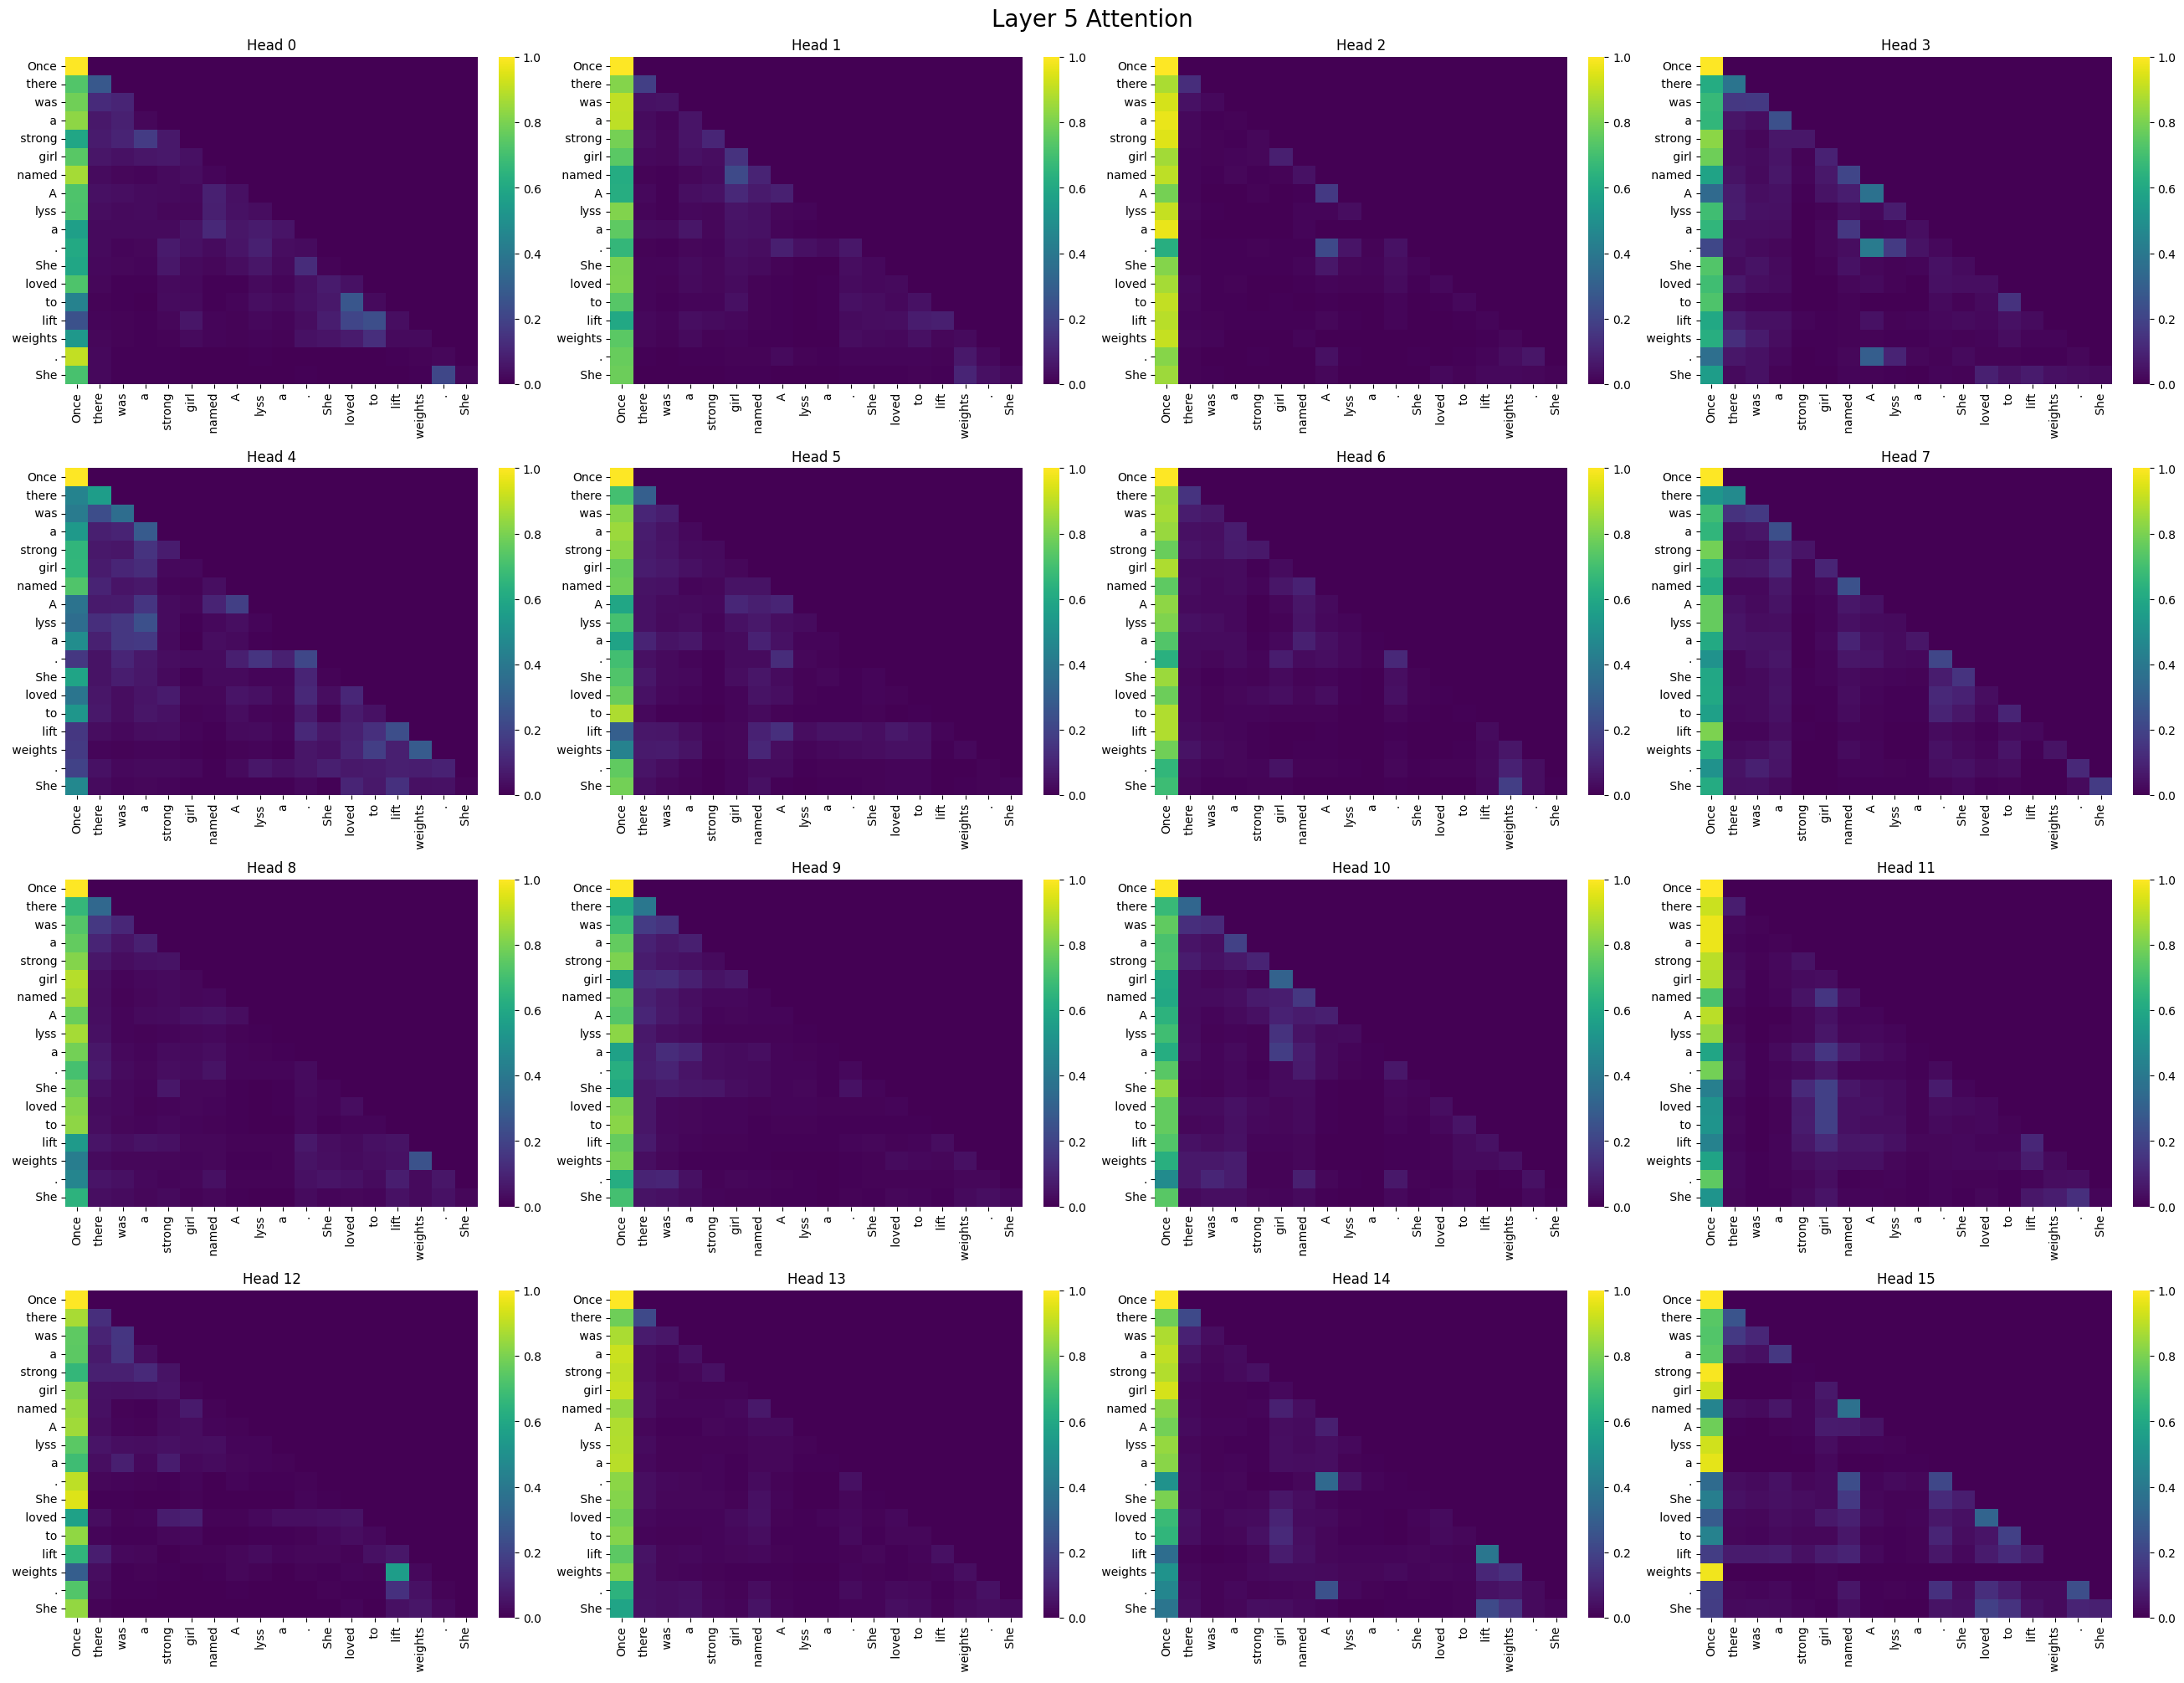

In [329]:
plot_layer_attention("Once there was a strong girl named Alyssa. She loved to lift weights. She",
                      model,
                      tokenizer,
                      layer_idx=5,
                      device=device)